Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2025-06-11 05:36:52.991103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749620213.013784  504980 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749620213.020685  504980 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#set the directories to use the data
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [3]:
#Extract Image Features
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

I0000 00:00:1749620216.808583  504980 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749620216.809236  504980 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1749620220.301802  505034 service.cc:148] XLA service 0x799e30003aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749620220.301837  505034 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749620220.301840  505034 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749620220.382947  505034 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749620222.368436  505034 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
#Load the Captions Data
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
#Number of images loaded
len(mapping)

8091

Preprocess Text Data

In [10]:
# clean and convert the text for quicker process and better results
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
            caption = captions[i]
        # preprocessing steps
        # convert to lowercase
            caption = caption.lower()
        # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
            caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:

# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
#store the preprocessed captions into a list
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
# checking number of unique captions
len(all_captions)

40455

In [16]:
# First 10 captions
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
import pickle
# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [19]:
vocab_size

8485

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [21]:
#Train Test Split or training
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

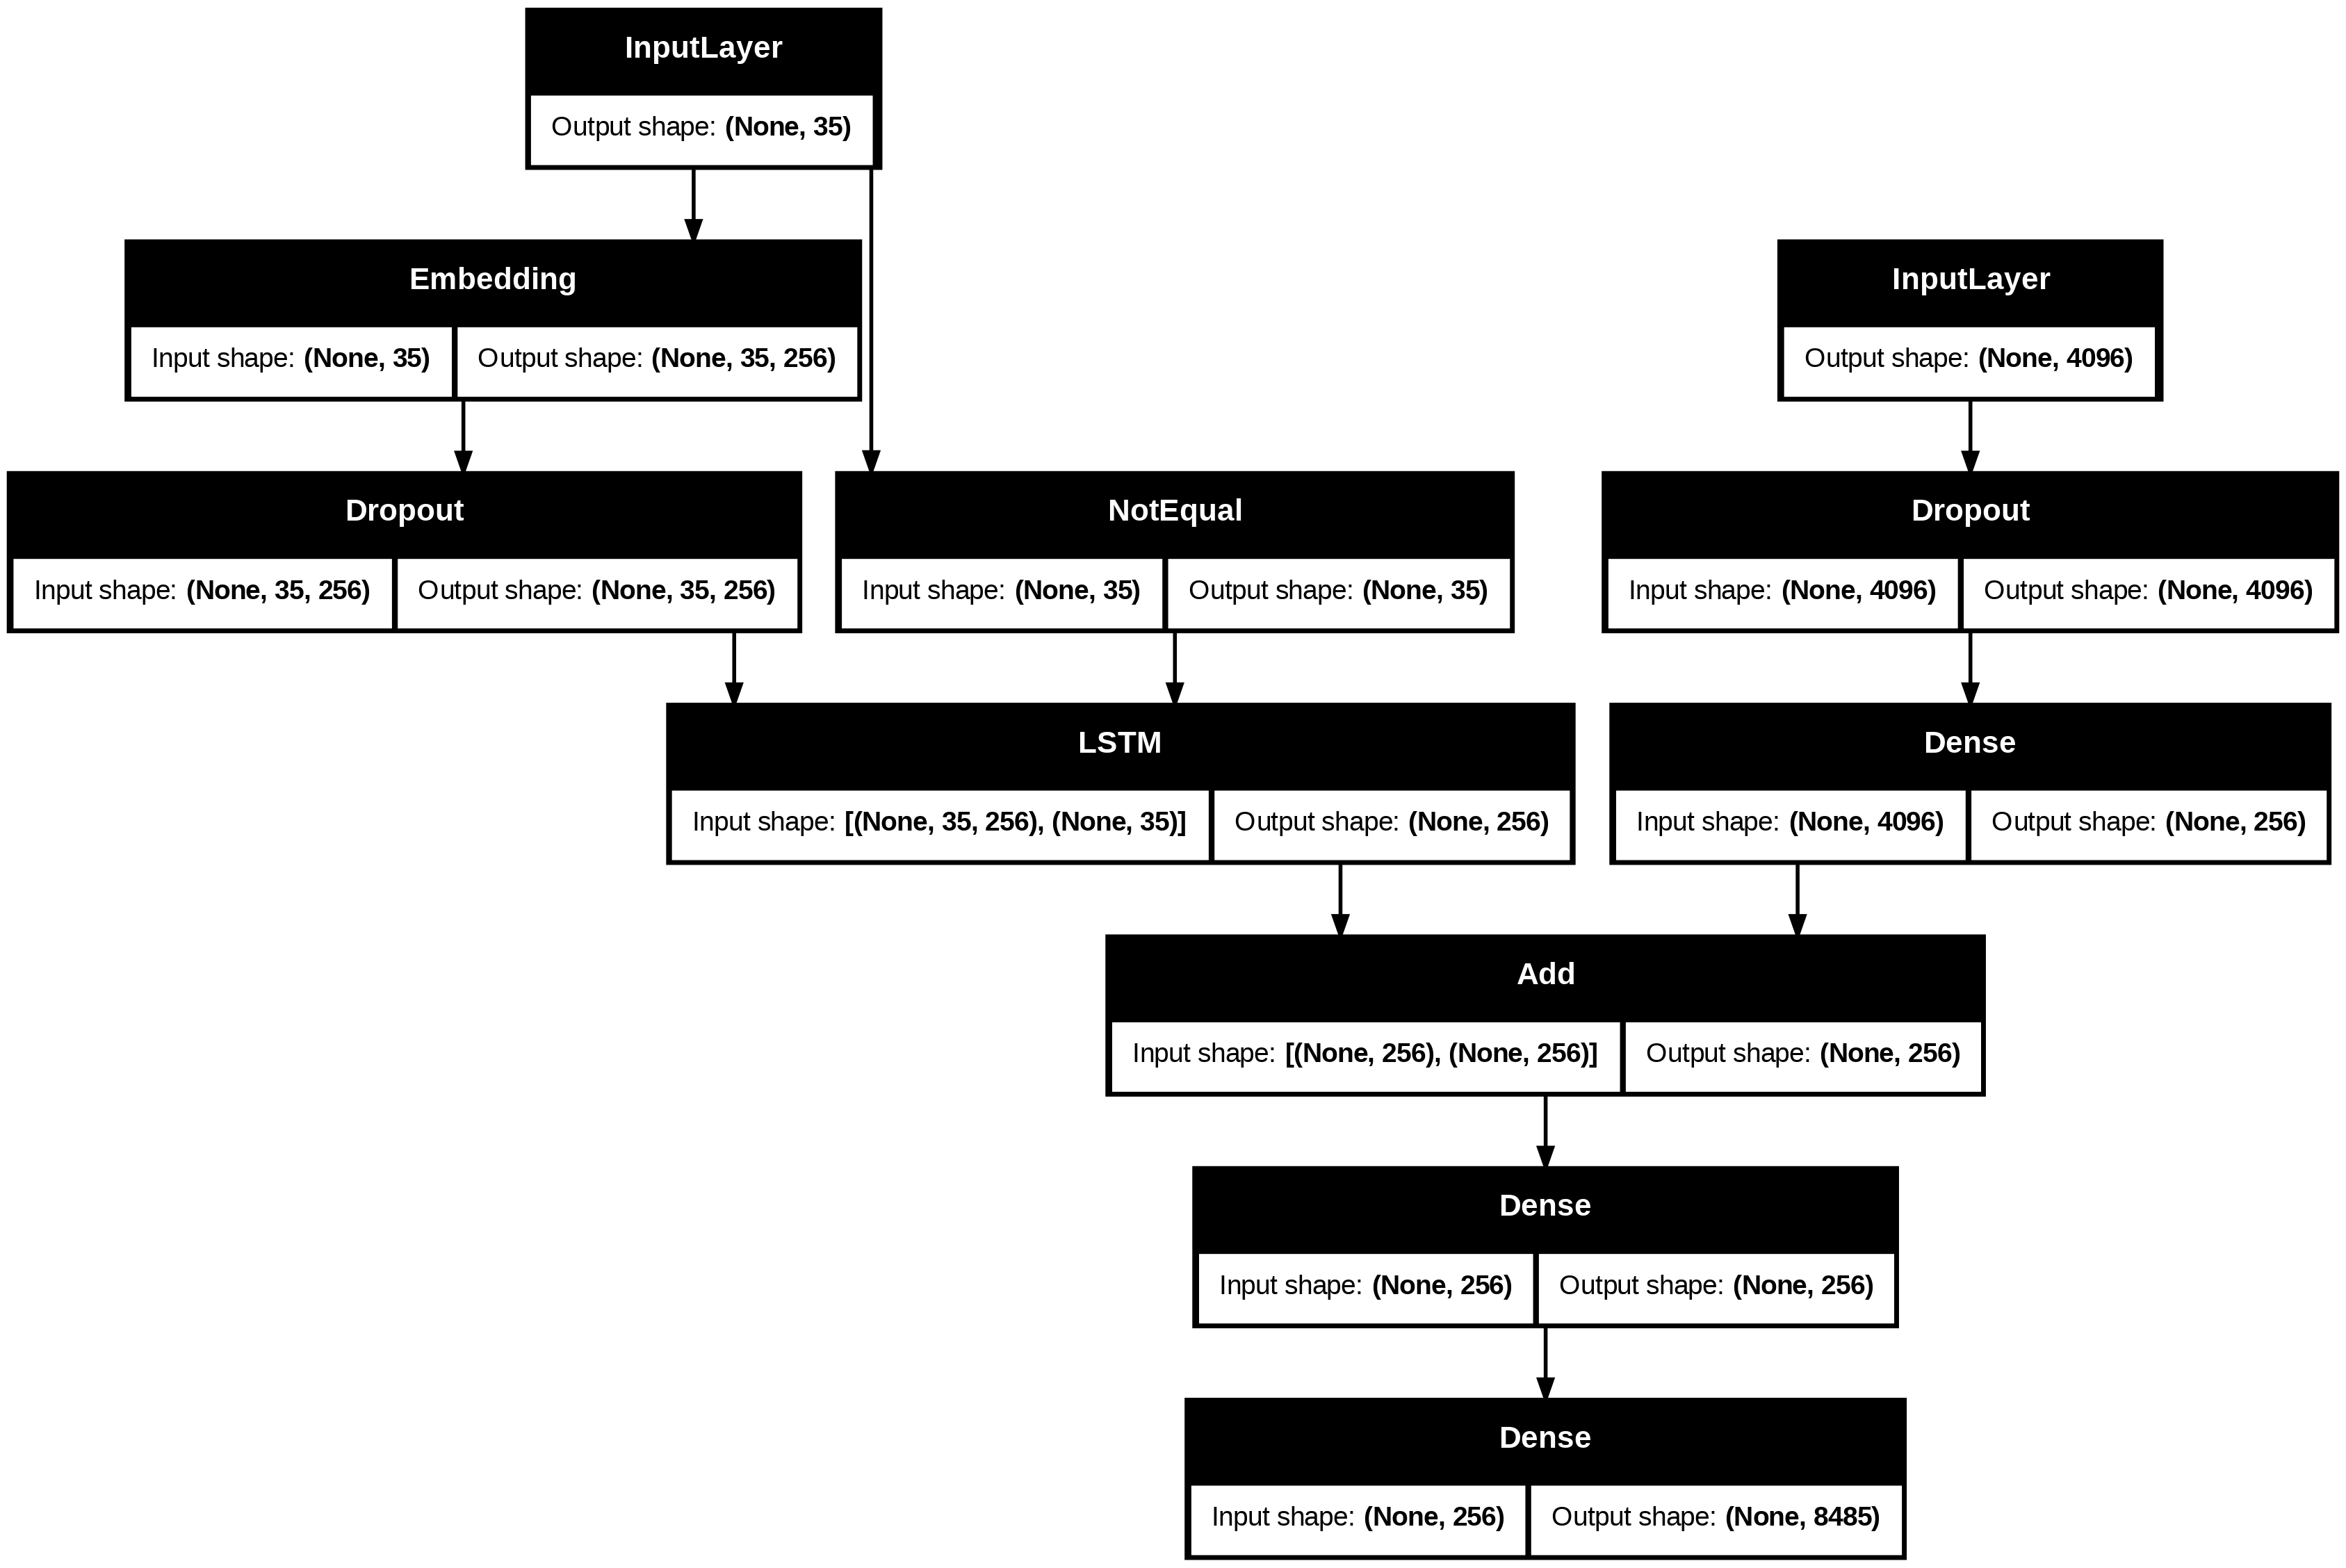

In [23]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [24]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 234ms/step - loss: 5.7617
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 4.0731
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 3.6036
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 231ms/step - loss: 3.3202
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 3.1116
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.9576
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.8377
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 231ms/step - loss: 2.7421
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.6658
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.5985
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.5341
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 219ms/step - loss: 2.4745
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.4237
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.3797
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 2.3376
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.2989
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 2.26

In [25]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [26]:
model.save(WORKING_DIR+'/best_model.keras')  # note the extension change

Generate Captions for the Image

In [27]:
#Convert the predicted index from the model into a word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [29]:
#validate the data using BLEU Score
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

actual, predicted = [], []

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred_tokens = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred_tokens)

# Now print BLEU scores only once here:
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [10:44<00:00,  1.26it/s]


BLEU-1: 0.529392
BLEU-2: 0.302745


In [30]:
from nltk.translate.meteor_score import meteor_score

# Calculate METEOR
meteor_scores = []
for refs, pred in zip(actual, predicted):
    meteor_scores.append(meteor_score(refs, pred))  # both are tokenized
print("METEOR: %f" % (sum(meteor_scores) / len(meteor_scores)))


METEOR: 0.377067


In [31]:
!git clone https://github.com/salaniz/pycocoevalcap.git
!pip install -r pycocoevalcap/requirements.txt
!cd pycocoevalcap && python setup.py install

fatal: destination path 'pycocoevalcap' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pycocoevalcap/requirements.txt'
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        **********************************************************************

In [32]:
#Calculate CIDEr

from pycocoevalcap.cider.cider import Cider

# COCO-style format using dummy IDs
gts = {}  # ground truths
res = {}  # predictions

for i, (refs, pred) in enumerate(zip(actual, predicted)):
    gts[i] = [" ".join(ref) for ref in refs]    # multiple ground truth captions
    res[i] = [" ".join(pred)]                   # one generated caption

# Compute CIDEr score
cider_scorer = Cider()
score, _ = cider_scorer.compute_score(gts, res)
print("CIDEr: %f" % score)

CIDEr: 0.307412


Visualize the Results

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing together on sidewalk endseq


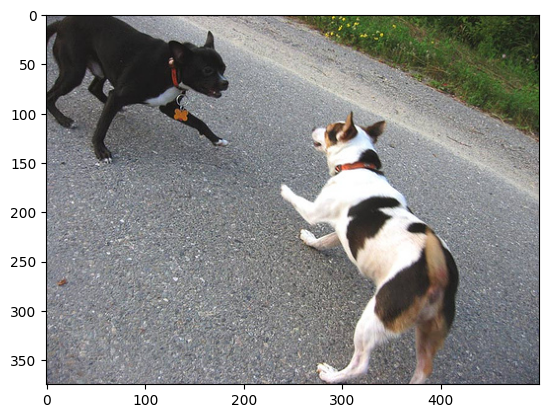

In [34]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq man and baby are in yellow kayak on water endseq
startseq man and little boy in blue life jackets are rowing yellow canoe endseq
startseq man and child kayak through gentle waters endseq
startseq man and young boy ride in yellow kayak endseq
startseq man and child in yellow kayak endseq
--------------------Predicted--------------------
startseq man in yellow kayak is floating in the water endseq


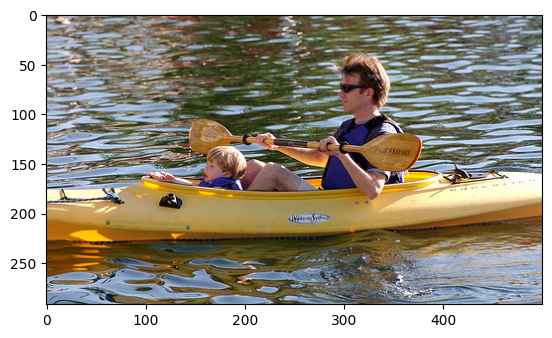

In [49]:
generate_caption("1028205764_7e8df9a2ea.jpg")

Test with Real Image

In [37]:
#VGG model is used for feature extraction of the image
vgg_model = VGG16() 
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,             
                  outputs=vgg_model.layers[-2].output)

In [64]:
image_path = '/kaggle/input/modell2/model2.jpeg'

# load image
image = load_img(image_path, target_size=(224, 224))

# convert image pixels to numpy array
image = img_to_array(image)

# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# preprocess image from vgg
image = preprocess_input(image)

# extract features
feature = vgg_model.predict(image, verbose=0)

# predict from the trained model
caption = predict_caption(model, feature, tokenizer, max_length)

# clean caption
caption = caption.replace('startseq', '').replace('endseq', '').strip()
caption = caption.capitalize() + '.'

# print final caption
print(caption)

Two dogs are playing in the grass.


In [61]:
image_path = '/kaggle/input/model4/model4.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq toddler sucking binky around endseq'

In [66]:
image_path = '/kaggle/input/modell2/model2.jpeg'

# load image
image = load_img(image_path, target_size=(224, 224))

# convert image pixels to numpy array
image = img_to_array(image)

# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# preprocess image from vgg
image = preprocess_input(image)

# extract features
feature = vgg_model.predict(image, verbose=0)

# predict from the trained model
caption = predict_caption(model, feature, tokenizer, max_length)

# clean caption
caption = caption.replace('startseq', '').replace('endseq', '').strip()
caption = caption.capitalize() + '.'

# print final caption
print(caption)

Two dogs are playing in the grass.


In [63]:
image_path = '/kaggle/input/model1/model1.jpg'

# load image
image = load_img(image_path, target_size=(224, 224))

# convert image pixels to numpy array
image = img_to_array(image)

# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# preprocess image from vgg
image = preprocess_input(image)

# extract features
feature = vgg_model.predict(image, verbose=0)

# predict from the trained model
caption = predict_caption(model, feature, tokenizer, max_length)

# clean caption
caption = caption.replace('startseq', '').replace('endseq', '').strip()
caption = caption.capitalize() + '.'

# print final caption
print(caption)

Man sleeping on bench.


In [65]:
image_path = '/kaggle/input/model4/model4.jpg'

# load image
image = load_img(image_path, target_size=(224, 224))

# convert image pixels to numpy array
image = img_to_array(image)

# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# preprocess image from vgg
image = preprocess_input(image)

# extract features
feature = vgg_model.predict(image, verbose=0)

# predict from the trained model
caption = predict_caption(model, feature, tokenizer, max_length)

# clean caption
caption = caption.replace('startseq', '').replace('endseq', '').strip()
caption = caption.capitalize() + '.'

# print final caption
print(caption)

Toddler sucking binky around.
